In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_datasets as tfds
import numpy as np


Use Masking Layer to create an ImageNet that only predicts for Stanford Dogs dataset.
Need mapping list of indices between full ImageNet and Stanford Dogs.

Concept:
start with existing Stanford Dogs notebook about transfer learning.
Need mapping list of indices between full ImageNet and Stanford Dogs.

Load ImageNet model.
Download any subset of ImageNet with original indexes, preferably a mix with some dogs.
Predict from subset
Display misclassified image pairs. 


Stanford Dogs section
Create 2-way mapping tables
Predict SD only:
Create Dataset which maps index to ImageNet index
Predict Stanford Dogs from ImageNet with evaluate.
Predict again, pulling logits, counting misclassified outside of SD index list.
Display misclassified outside 

Save weights to file.
Pop final Dense layer.
Get name and config params, verify activation = softmax
Create new Dense layer with same shape and name, no activation.
Create simple Model with just Dense layer
'load weights by name' into new Model
now have Dense with no activation
Add Dense to ImageNet model.
Add Masking to ImageNet model.
Add Softmax layer.



In [3]:

IMG_SIZE = 224
DENSE_INPUT = 1280
IMAGENET_CLASSES = 1000
batch_size = 64



The Stanford Dogs image set is a subset of ImageNet-1000, and occupies a few ranges of indexes in the larger dataset. (Stanford Dogs does not include several wild canid species, sticking entirely to domestic breeds.) The Stanford Dogs label range is different than IN-1k, so we have to map the indexes back to the IN-1k index range. 

In [4]:
def sd2imagenet(index):
    if index >= 0 and index <= 99:
        return index + 151
    elif index >= 100 and index <= 116:
        return index + 152
    elif index >= 117 and index <= 119:
        return index + 156
    else:
        return -1

def imagenet2sd(index):
    if index >= 151 and index <= 250:
        return index - 151
    elif index >= 252 and index <= 268:
        return index - 152
    elif index >= 273 and index <= 275:
        return index - 156
    else:
        return -1

def get_sd_mask():
    masks = [0.0] * IMAGENET_CLASSES 
    for index in range(SD_CLASSES):
        masks[sd2imagenet(index)] = 1.0
    return masks

Load the Stanford Dogs TF Dataset, prepare iterators, and map the indexes.

In [5]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
def input_preprocess(image, label):
    mapped = sd2imagenet(int(label))
    onehot = tf.one_hot(mapped, IMAGENET_CLASSES)
    return image, onehot
ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
SD_CLASSES = ds_info.features["label"].num_classes
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
# forget input augmentation as we are not training
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteP1B4T0/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteP1B4T0/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
def clone_layer(layer):
    print('clone_layer:', layer.name)
    return layer.__class__.from_config(layer.get_config())

def build_masked_effnet():
    effnet = EfficientNetB0(weights='imagenet')
    effnet.trainable = False
    m = tf.keras.models.Sequential()
    m.add(effnet)

    mask_layer = tf.keras.layers.Lambda(lambda x: x * get_sd_mask())
    m.add(mask_layer)
    m.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
    return m

In [7]:
effnet = EfficientNetB0(weights='imagenet')
effnet.trainable = False
effnet.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
print(effnet.evaluate(ds_train))
print(effnet.evaluate(ds_test))


187/187 [==============================] - 38s 132ms/step - loss: 0.6416 - accuracy: 0.8507
[0.6415883302688599, 0.850685179233551]
134/134 [==============================] - 18s 129ms/step - loss: 0.6182 - accuracy: 0.8631
[0.6181910634040833, 0.863106369972229]


In [8]:
masked = build_masked_effnet()
print(masked.evaluate(ds_train))
print(masked.evaluate(ds_test))

187/187 [==============================] - 28s 133ms/step - loss: 0.5326 - accuracy: 0.8557
[0.5326246023178101, 0.8556985259056091]
134/134 [==============================] - 18s 132ms/step - loss: 0.5066 - accuracy: 0.8693
[0.5065962076187134, 0.8692863583564758]


In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

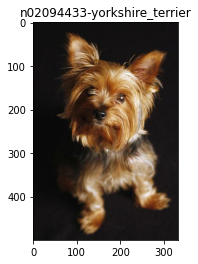

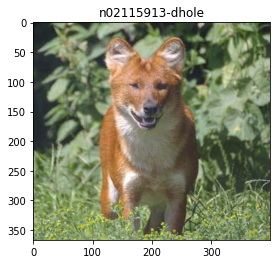

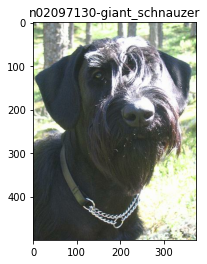

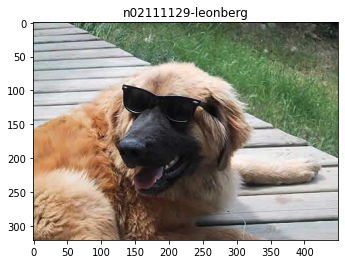

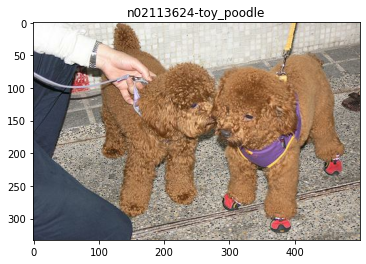

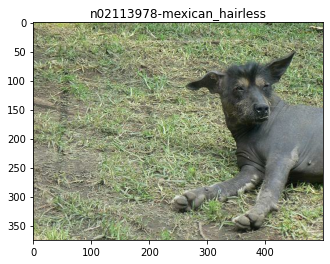

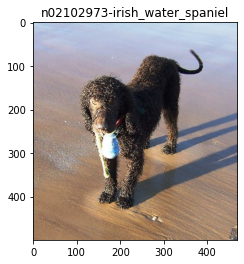

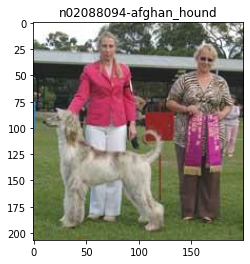

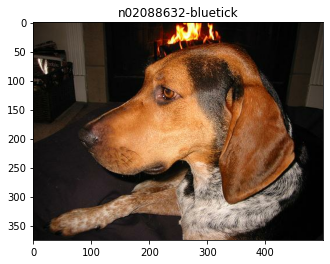

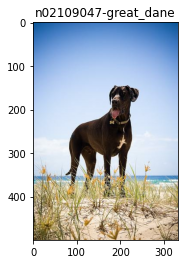

In [10]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

big (500, 333, 3)
box (4,) [0.044     0.2102102 0.972     0.960961 ]
ibox [ 21 323 105 320]
img <PIL.Image.Image image mode=RGB size=215x302 at 0x7F5393413F50>
resized <PIL.Image.Image image mode=RGB size=224x224 at 0x7F5393413A10>
small (224, 224, 3)
big (367, 400, 3)
box (4,) [0.07084469 0.28       0.98092645 0.6975    ]
ibox [ 26 392 102 278]
img <PIL.Image.Image image mode=RGB size=176x341 at 0x7F5396722C90>
resized <PIL.Image.Image image mode=RGB size=224x224 at 0x7F5391B08510>
small (224, 224, 3)
big (500, 375, 3)
box (4,) [0.062      0.         0.996      0.96533334]
ibox [ 30 373   0 362]
img <PIL.Image.Image image mode=RGB size=362x343 at 0x7F5391AEE710>
resized <PIL.Image.Image image mode=RGB size=224x224 at 0x7F5393EBBD10>
small (224, 224, 3)
big (321, 450, 3)
box (4,) [0.18068536 0.00444444 0.99688476 0.9488889 ]
ibox [ 57 448   1 427]
img <PIL.Image.Image image mode=RGB size=426x264 at 0x7F5393D97CD0>
resized <PIL.Image.Image image mode=RGB size=224x224 at 0x7F53933F9BD0>


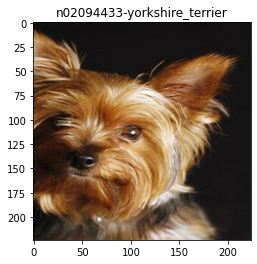

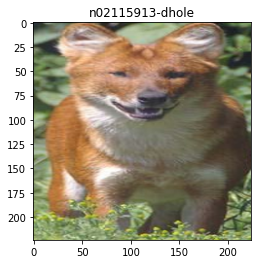

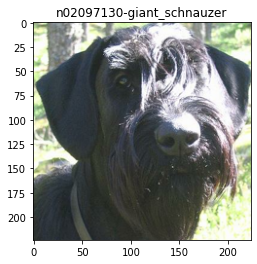

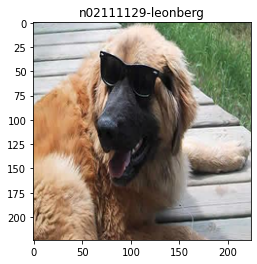

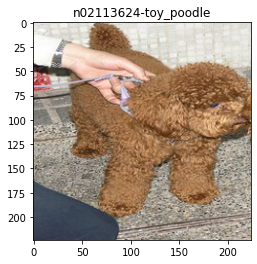

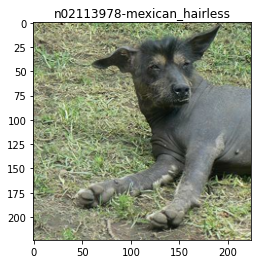

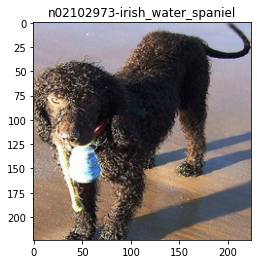

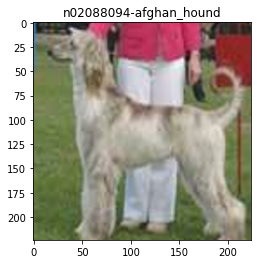

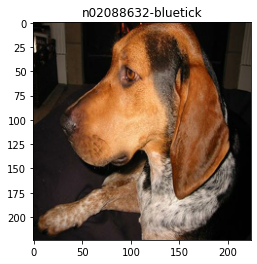

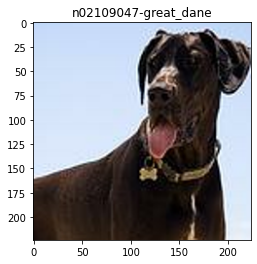

In [32]:
from PIL import Image
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

get_name = info.features['label'].int2str

def clip(big, box):
    print('big', big.shape)
    h = big.shape[0]
    w = big.shape[1]
    print('box', box.shape, box)
    ibox = np.zeros((4,), dtype='int32')
    tup = [0,2,1,3]
    ibox[0] = box[tup[0]] * h
    ibox[1] = box[tup[1]] * w
    ibox[2] = box[tup[2]] * h
    ibox[3] = box[tup[3]] * w
    print('ibox', ibox)
    small = big[ibox[0]:ibox[1], ibox[2]:ibox[3], :]
    return small
    
def resize(part):
    part = part # * 255
    img = Image.fromarray(part, mode='RGB')
    print('img', img)
    resized = img.resize((IMG_SIZE, IMG_SIZE))
    print('resized', resized)
    out = np.asarray(resized)
    return out 

for doggo in dataset['train'].take(10):
    plt.figure()
    big = doggo['image'].numpy()
    box = doggo['objects']['bbox'].numpy()[0]
    clipped = clip(big, box)
    small = resize(clipped)
    print('small', small.shape)
    plt.imshow(small)
    plt.title(get_name(doggo['label']))

In [ ]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
    plt.figure()
    big = doggo['image']
    print(big.shape)
    big = big.numpy()
    print('big', big.shape)
    box = doggo['objects']['bbox']
    box = np.asarray(box.numpy() * IMG_SIZE, dtype='int32')[0]
    print(box)
    small = big[box[0]:box[1], box[2]:box[3], :]
    print(small)
    plt.imshow(small)
    plt.title(get_name(doggo['label']))